# EDA 
explore datasets and make dataframes containing metadata for each set if one is not provided 

In [33]:
import pandas as pd
import os 
import matplotlib.pyplot as plt 
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import seaborn as sns 
import torch 
import torchaudio 


# AVSP-ESD Dataset 

source: https://www.kaggle.com/dejolilandry/asvpesdspeech-nonspeech-emotional-utterances


# Data Preperation 
Since the dataset didnt come with a CSV file containing the metadata we'll create a dataframe that contains the Path to the Wav file and it Class which is what emotion it has been labeled as. 

Taken from the Kaggle Dataset Descri

Each wav file in the dataset consists of numerical identifiers. 

Filename identifiers:
Modality ( 03 = audio-only).
Vocal channel on s(01 = speech, 02 = npeech).
Emotion ( 01 = boredom, 02 = neutral, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised, 09 = excited, 10 = pleasure, 11 = pain, 12 = disappointment, 13 = others).
Emotional intensity (01 = normal, 02 = high).
Statement (as it’s non scripted this refer to the number of sample select per actor folder ).
Actor ( even numbered acteurs are male, odd numbered actors are female).
Age(01 = above 65, 02 = between 20~64, 03 = under 20,04=new born).
Source of downloading (01 =website , 02 = youtube channel, 03= movies).
Language(01=Chinese , 02=English ,04 = french , others).


In [2]:
asvp_labels_dict = {
    1: 'boredom', 
    2: 'neutral',
    3: 'happy',
    4: 'sad',
    5: 'angry',
    6: 'fearful',
    7: 'disgust', 
    8: 'surprised',
    9: 'excited', 
    10: 'pleasure',
    11: 'pain', 
    12: 'disappointment', 
    13: 'others'
}

So by taking a look at how the data is labeled we can decide how to make classification for our problem. Lets start simple and just use the Emotion label. Later we can try classifying other labels like age and gender. We'll also only use files labeled as speech, later we'll use the non speech files for data augmentation but more on that later. for now lets make a list 

In [3]:
# lets practice taking the path strings apart 
ster = "/Users/stephen/Desktop/Speech_Recognition/Data/ASVP-ESD_UPDATE/Audio/actor_13/03-01-02-01-06-13-02-03-01.wav"
part = ster.split('/')[-1]
part = part.split('.')[0]
part = part.split('-')
print(part)

['03', '01', '02', '01', '06', '13', '02', '03', '01']


In [4]:
# take a look at all the folders  

# string representing PATH for folder containing data
asvp_audio_path = '/Users/stephen/Desktop/Speech_Recognition/Data/ASVP-ESD_UPDATE/Audio/'

# the dataset is organized into folders for each actor/actress. the listdir method will list all contained folders 
asvp_dir_list = os.listdir(asvp_audio_path)

# iterate through files and 
for dir in asvp_dir_list:
    print(dir)



actor_16
actor_29
actor_11
actor_27
actor_18
actor_20
actor_74
actor_80
actor_87
actor_73
actor_103
actor_45
actor_89
actor_42
actor_104
actor_21
actor_26
actor_19
actor_10
actor_17
actor_28
actor_88
actor_105
actor_43
actor_44
actor_102
actor_72
actor_86
actor_81
actor_75
actor_5
actor_2
.DS_Store
actor_3
actor_4
actor_57
actor_68
actor_50
actor_66
actor_59
actor_61
actor_35
actor_32
actor_60
actor_67
actor_58
actor_51
actor_56
actor_69
actor_33
actor_34
actor_84
actor_70
actor_48
actor_77
actor_83
actor_41
actor_79
actor_100
actor_46
actor_12
actor_15
actor_23
actor_24
actor_78
actor_47
actor_101
actor_106
actor_40
actor_49
actor_82
actor_76
actor_71
actor_85
actor_25
actor_22
actor_14
actor_13
actor_1
actor_6
actor_8
actor_9
actor_7
actor_0
actor_31
actor_36
actor_38
actor_53
actor_54
actor_62
actor_65
actor_91
actor_39
actor_37
actor_30
actor_90
actor_64
actor_63
actor_55
actor_52


you might not be able to see it from the long list of folders but DS_Store shows up and will cause an error if it is not delt with properly. We'll simply add a  conditional in the following function that will ignore the DS_Store file. 

In [5]:
for dir in asvp_dir_list:
    if dir != ".DS_Store":
        print(dir)

actor_16
actor_29
actor_11
actor_27
actor_18
actor_20
actor_74
actor_80
actor_87
actor_73
actor_103
actor_45
actor_89
actor_42
actor_104
actor_21
actor_26
actor_19
actor_10
actor_17
actor_28
actor_88
actor_105
actor_43
actor_44
actor_102
actor_72
actor_86
actor_81
actor_75
actor_5
actor_2
actor_3
actor_4
actor_57
actor_68
actor_50
actor_66
actor_59
actor_61
actor_35
actor_32
actor_60
actor_67
actor_58
actor_51
actor_56
actor_69
actor_33
actor_34
actor_84
actor_70
actor_48
actor_77
actor_83
actor_41
actor_79
actor_100
actor_46
actor_12
actor_15
actor_23
actor_24
actor_78
actor_47
actor_101
actor_106
actor_40
actor_49
actor_82
actor_76
actor_71
actor_85
actor_25
actor_22
actor_14
actor_13
actor_1
actor_6
actor_8
actor_9
actor_7
actor_0
actor_31
actor_36
actor_38
actor_53
actor_54
actor_62
actor_65
actor_91
actor_39
actor_37
actor_30
actor_90
actor_64
actor_63
actor_55
actor_52


In [6]:
test_path = '/Users/stephen/Desktop/Speech_Recognition/Data/ASVP-ESD_UPDATE/Audio/actor_8/03-01-02-01-05-08-02-03-01-03.wav'

test_info = torchaudio.info(test_path)
this = test_info.num_frames

this

135838

In [26]:
# string representing PATH for folder containing data
asvp_audio_path = '/Users/stephen/Desktop/Speech_Recognition/Data/ASVP-ESD_UPDATE/Audio/'

# the dataset is organized into folders for each actor/actress. the listdir method will list all contained folders 
asvp_dir_list = os.listdir(asvp_audio_path)


file_emotion = []
file_name = []
file_fold = []
file_sample_rate = []
file_num_frames = []
file_duration = []
file_full_path = []



# iterate through files and 
for dir in asvp_dir_list:
    if dir != ".DS_Store":
    # extract contents from each folder 
        actor = os.listdir(asvp_audio_path + dir)
    # go through each file in each folder 
        for file in actor: 
            part = file.split('.')[0] # ignore the .wav
            part = part.split('-')
            # the second part represents speech or non speech 
            if part[1] == '01': # 01 represents Speech 
                # third part represents emotion 
                file_emotion.append(int(part[2]))
                file_name.append('/' + file)
                file_fold.append(dir)

                full_path = os.path.join(asvp_audio_path + str(dir) + '/' + str(file))
                file_full_path.append(full_path)

                info = torchaudio.info(full_path)

                file_sample_rate.append(info.sample_rate)
                file_num_frames.append(info.num_frames)

                file_duration.append(info.num_frames / info.sample_rate)




# dataframe for emotion of files 
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files 
name_df = pd.DataFrame(file_name, columns=['Filename'])

# dataframe for names of folders 
fold_df = pd.DataFrame(file_fold, columns=['Folder'])

# dataframe for sample rates 
sr_df = pd.DataFrame(file_sample_rate, columns=['Sample_Rate'])

# dataframe for number of frames  
frames_df = pd.DataFrame(file_num_frames, columns=['Num_Frames'])

# dataframe for file duration 
duration_df = pd.DataFrame(file_duration, columns=['Duration'])

asvp_metadata = pd.concat([emotion_df, fold_df, name_df, sr_df, frames_df, duration_df], axis=1)

# change integers to actual emotions. 
asvp_metadata.Emotions.replace(asvp_labels_dict, inplace=True)
asvp_metadata.head()

,Emotions,Folder,Filename,Sample_Rate,Num_Frames,Duration
0,neutral,actor_16,/03-01-02-01-02-16-03-03-01.wav,16000,44305,2.769062
1,angry,actor_16,/03-01-05-02-07-16-03-03-01.wav,16000,96922,6.057625
2,neutral,actor_16,/03-01-02-01-13-16-03-03-01.wav,16000,58396,3.649750
3,neutral,actor_16,/03-01-02-01-05-16-03-03-01.wav,16000,13794,0.862125
4,angry,actor_16,/03-01-05-02-06-16-03-03-01.wav,16000,49738,3.108625


In [27]:
file_full_path[0]

'/Users/stephen/Desktop/Speech_Recognition/Data/ASVP-ESD_UPDATE/Audio/actor_16/03-01-02-01-02-16-03-03-01.wav'

In [28]:
ts, sr = torchaudio.load('/Users/stephen/Desktop/Speech_Recognition/Data/ASVP-ESD_UPDATE/Audio/actor_16/03-01-02-01-02-16-03-03-01.wav')
ts

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0114,  0.0099, -0.0018]])

In [29]:
asvp_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3946 entries, 0 to 3945
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Emotions     3946 non-null   object 
 1   Folder       3946 non-null   object 
 2   Filename     3946 non-null   object 
 3   Sample_Rate  3946 non-null   int64  
 4   Num_Frames   3946 non-null   int64  
 5   Duration     3946 non-null   float64
dtypes: float64(1), int64(2), object(3)
memory usage: 185.1+ KB


In [34]:
asvp_metadata['Emotions'].value_counts()

neutral           1019
angry              987
happy              495
sad                471
surprised          327
disappointment     241
fearful            137
disgust             93
excited             92
pain                36
boredom             26
pleasure            22
Name: Emotions, dtype: int64

In [41]:
# Sanity check to make sure the Path Column contains the fill path 
asvp_metadata['Duration'].describe()

count    3946.000000
mean        6.275889
std         3.610489
min         0.379312
25%         3.190766
50%         6.000000
75%         9.150063
max        30.563312
Name: Duration, dtype: float64

/Users/stephen/opt/anaconda3/envs/torch_env/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


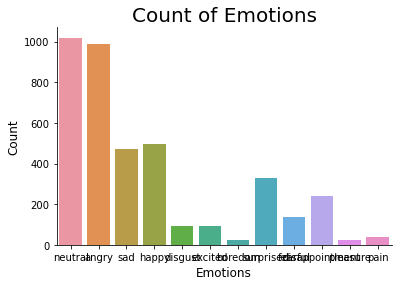

In [35]:
plt.title('Count of Emotions', size=20)
sns.countplot(asvp_metadata.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

# Duration of files 
all observations(in this case its the wav files) must be the same length when we input it into a Neural Network. lets take a look at the data so when it comes time for preprocessing we'll have info already

In [38]:
asvp_metadata['Duration'].describe()

count    3946.000000
mean        6.275889
std         3.610489
min         0.379312
25%         3.190766
50%         6.000000
75%         9.150063
max        30.563312
Name: Duration, dtype: float64

(array([1094., 1015.,  912.,  818.,   67.,   19.,   10.,    5.,    4.,
           2.]),
 array([ 0.3793125,  3.3977125,  6.4161125,  9.4345125, 12.4529125,
        15.4713125, 18.4897125, 21.5081125, 24.5265125, 27.5449125,
        30.5633125]),
 <BarContainer object of 10 artists>)

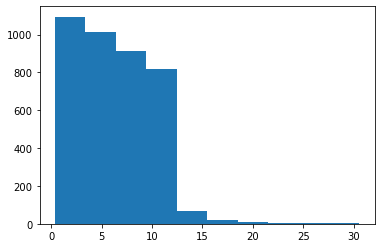

In [44]:
fig, ax = plt.subplots()
ax.hist(asvp_metadata['Duration'], bins=10)

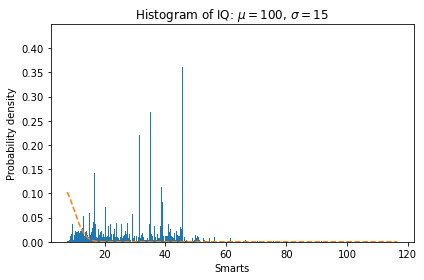

In [89]:
mu = asvp_metadata['Duration'].mean()  # mean of distribution 
sigma = asvp_metadata['Duration'].std()  # standard deviation of distribution 
x = mu + sigma * asvp_metadata['Duration']

num_bins = 1000

fig, ax = plt.subplots()

# histogram of data duration 
n, bins, patches = ax.hist(x, num_bins, density=1)

# add a 'best fit' line
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax.plot(bins, y, '--')
ax.set_xlabel('Smarts')
ax.set_ylabel('Probability density')
ax.set_title(r'Histogram of IQ: $\mu=100$, $\sigma=15$')

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()



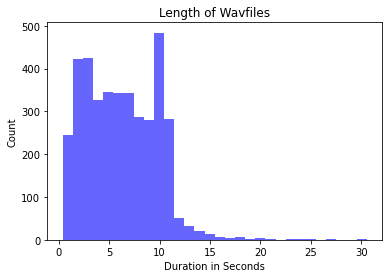

In [74]:
plt.hist(asvp_metadata['Duration'], bins=30, density=False, alpha=0.6, color='b')
plt.xlabel('Duration in Seconds')
plt.ylabel('Count')
plt.title('Length of Wavfiles')
plt.show()

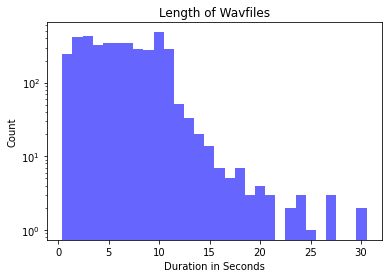

In [80]:
# Log scaled Histogram 

ytic = [range(0,30)]

plt.hist(asvp_metadata['Duration'], bins=30, density=False, alpha=0.6, color='b', log=True)
plt.xlabel('Duration in Seconds')
plt.ylabel('Count')

plt.title('Length of Wavfiles')
plt.show()

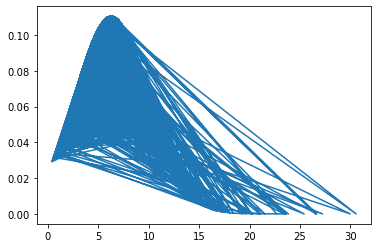

In [68]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import statistics
    
# Plot between -30 and 30 with
# 0.1 steps.
x_axis = asvp_metadata['Duration']
    
# Calculating mean and standard 
# deviation
mean = statistics.mean(x_axis)
sd = statistics.stdev(x_axis)
    
plt.plot(x_axis, norm.pdf(x_axis, mean, sd))
plt.show()

In [93]:
mu = asvp_metadata['Duration'].mean()  # mean of distribution 
sigma = asvp_metadata['Duration'].std()  # standard deviation of distribution 
print(mu, sigma)
mean = np.mean(asvp_metadata['Duration'])
stan = np.std(asvp_metadata['Duration'])
print(mean, stan)

6.275888969842883 3.6104889269337215
6.275888969842883 3.6100314107528395


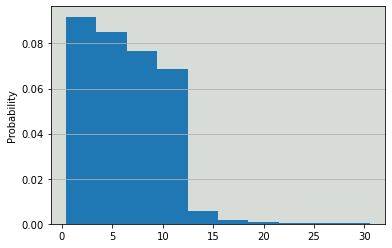

In [96]:
fig, ax = plt.subplots()

asvp_metadata['Duration'].plot.hist(density=True, ax=ax)
ax.set_ylabel('Probability')
ax.grid(axis='y')
ax.set_facecolor('#d8dcd6')

Text(-2.0, 0.35, '$f(x) = \\frac{\\exp(-x^2/2)}{\\sqrt{2*\\pi}}$')

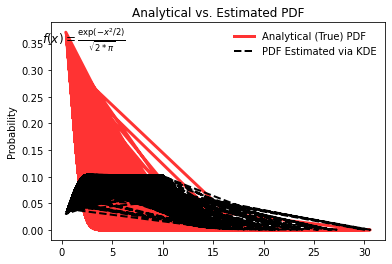

In [97]:
from scipy import stats 

dist = stats.norm()


# `ppf()`: percent point function (inverse of cdf — percentiles).
x = asvp_metadata['Duration']
gkde = stats.gaussian_kde(dataset=asvp_metadata['Duration'])

# `gkde.evaluate()` estimates the PDF itself.
fig, ax = plt.subplots()
ax.plot(x, dist.pdf(x), linestyle='solid', c='red', lw=3,
        alpha=0.8, label='Analytical (True) PDF')
ax.plot(x, gkde.evaluate(x), linestyle='dashed', c='black', lw=2,
        label='PDF Estimated via KDE')
ax.legend(loc='best', frameon=False)
ax.set_title('Analytical vs. Estimated PDF')
ax.set_ylabel('Probability')
ax.text(-2., 0.35, r'$f(x) = \frac{\exp(-x^2/2)}{\sqrt{2*\pi}}$',
        fontsize=12)

In [109]:
asvp_metadata['Duration'].round().value_counts()

10.0    485
2.0     426
3.0     410
6.0     355
5.0     336
7.0     332
4.0     318
8.0     289
9.0     282
1.0     276
11.0    276
12.0     52
13.0     28
14.0     20
15.0     14
0.0       7
18.0      7
16.0      7
17.0      5
20.0      4
27.0      3
19.0      3
24.0      3
23.0      2
21.0      2
25.0      1
31.0      1
30.0      1
22.0      1
Name: Duration, dtype: int64

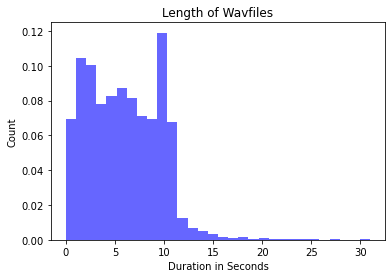

In [118]:
plt.hist(asvp_metadata['Duration'].round(), bins=30, density=True, alpha=0.6, color='b')
plt.xlabel('Duration in Seconds')
plt.ylabel('Count')
plt.title('Length of Wavfiles')
plt.show()

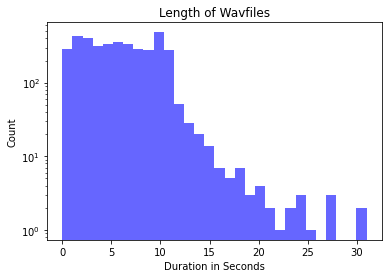

In [117]:
# Log scaled Histogram 

ytic = [range(0,30)]

plt.hist(asvp_metadata['Duration'].round(), bins=30, density=False, alpha=0.6, color='b', log=True)
plt.xlabel('Duration in Seconds')
plt.ylabel('Count')

plt.title('Length of Wavfiles')
plt.show()

In [119]:
asvp_metadata['Duration'] <= 10.0

0        True
1        True
2        True
3        True
4        True
        ...  
3941    False
3942    False
3943    False
3944    False
3945     True
Name: Duration, Length: 3946, dtype: bool

In [121]:
asvp_metadata.describe()

,Sample_Rate,Num_Frames,Duration
count,3946.0,3946.000000,3946.000000
mean,16000.0,100414.223517,6.275889
std,0.0,57767.822831,3.610489
min,16000.0,6069.000000,0.379312
25%,16000.0,51052.250000,3.190766
50%,16000.0,96000.000000,6.000000
75%,16000.0,146401.000000,9.150063
max,16000.0,489013.000000,30.563312


In [125]:
asvp_metadata['Emotions'].value_counts()

neutral           1019
angry              987
happy              495
sad                471
surprised          327
disappointment     241
fearful            137
disgust             93
excited             92
pain                36
boredom             26
pleasure            22
Name: Emotions, dtype: int64

In [129]:
asvp_metadata.to_csv('/Users/stephen/Desktop/Speech_Recognition/Data/ASVP-ESD_UPDATE/asvp_metadata.csv')

# Sum of length for each label 


In [134]:
asvp_metadata.groupby(asvp_metadata['Emotions'])['Duration'].sum().sort_values(ascending=False)

Emotions
neutral           6999.438375
angry             6553.868875
sad               3371.694937
happy             2836.666187
disappointment    2061.404625
surprised         1003.466063
fearful            590.392875
excited            562.552000
disgust            323.158625
pain               237.229750
boredom            125.697500
pleasure            99.088063
Name: Duration, dtype: float64